In [1]:
import numpy as np
import scanpy as sc
import anndata
import scvi
from scib_metrics.benchmark import Benchmarker
import torch
import scib_metrics
from lightning.pytorch.callbacks import ModelCheckpoint
import copy
%matplotlib inline
import sys
sys.path.append('..')
from functions import *
from SCVIModelCheckpoint import SCVIModelCheckpoint 

/local/data/scvi-tools/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/local/data/scvi-tools/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  dispatcher = jit(_target='npyufunc',
/local/data/anaconda3/envs/BT/lib/python3.11/site-pac

In [2]:
adata = anndata.read_h5ad(filename="../data/adataLung4.h5ad")
scvi.model.SCVI.setup_anndata(adata, layer="counts")

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [3]:
adata

AnnData object with n_obs × n_vars = 32472 × 4000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'Scanorama', 'Unintegrated', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [4]:
def trainMetricsEpochs(vae, folder, beta, n_epochs_kl_warmup,  max_epochs, every_n = 10, log=False,logname="", early_stopping=False):
    logger = None
    if log:
        logger = TensorBoardLogger(save_dir="lightning_logs",name=logname)
    checkpoint_callback = SCVIModelCheckpoint(dirpath= f"/local/data/BachelorThesis/metaExperiments/models/{folder}/",save_last=False,filename="{epoch:d}",every_n_epochs=every_n,save_top_k=-1,scviModel=vae)
    vae.train(enable_checkpointing = True,  max_epochs = max_epochs, callbacks=[checkpoint_callback], check_val_every_n_epoch=1,logger=logger,early_stopping=early_stopping,plan_kwargs={"max_kl_weight":beta,"n_epochs_kl_warmup":n_epochs_kl_warmup})

In [5]:
def getBenchmarkResultsEpochs(adata,dir,max_epochs,n_eps=10):
    adatac = adata.copy()
    keys = []
    for i in range(int(max_epochs/n_eps)-1):
        vae = scvi.model.SCVI.load(f"{dir}epoch={n_eps*i+n_eps-1}/",adata=adata)
        keys.append(f"scVIepoch={n_eps*i+n_eps-1}")
        adatac.obsm[keys[i]] = vae.get_latent_representation()
    return runBenchmark(adatac, keys, nmi_ari_cluster_labels_leiden=True, nmi_ari_cluster_labels_kmeans=True, silhouette_label=True,silhouette_batch=True, kbet_per_label=True)

In [6]:
def plotMetricsEpochs(bm,  max_epochs, n_eps = 10):
    benchmark_results = bm.get_results(min_max_scale=False)
    metrics = benchmark_results.keys()
    metrics_results = []
    for i in range(len(metrics)):
        metrics_results.append([])
        for j in range(int(max_epochs/n_eps)):
            metrics_results[i].append(benchmark_results[metrics[i]][f"scVIepoch={n_eps*j+n_eps-1}"])
        plt.plot(np.linspace(n_eps-1,max_epochs-1, int(max_epochs/n_eps)),metrics_results[i])
        plt.title(metrics[i])
        plt.xlabel("Epoch")
        plt.show()

In [7]:
vaeSD = scvi.model.SCVI(adata,prior_distribution='sdnormal')
vaeMG = scvi.model.SCVI(adata,prior_distribution='mixofgaus')
vaeVP = scvi.model.SCVI(adata,prior_distribution='vamp')
vaeNF = scvi.model.SCVI(adata,prior_distribution='normalflow',prior_kwargs={"num_layers":8})

In [8]:
trainMetricsEpochs(vaeSD, "MetEp_SD", 5, 200, 300, every_n=5, log=True, logname="MetEps300SD")
bmSD = getBenchmarkResultsEpochs(adata,"models/MetEp_SD/",300,5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/MetEps300SD
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [13:12<00:00,  2.75s/it, v_num=0, train_loss_step=979, train_loss_epoch=930]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [13:12<00:00,  2.64s/it, v_num=0, train_loss_step=979, train_loss_epoch=930]
INFO     File models/MetEp_SD/epoch=4/model.pt already downloaded                                                  
INFO     File models/MetEp_SD/epoch=9/model.pt already downloaded                                                  
INFO     File models/MetEp_SD/epoch=14/model.pt already downloaded                                                 
INFO     File models/MetEp_SD/epoch=19/model.pt already downloaded                                                 
INFO     File models/MetEp_SD/epoch=24/model.pt already downloaded                                                 
INFO     File models/MetEp_SD/epoch=29/model.pt already downloaded                                                 
INFO     File models/MetEp_SD/epoch=34/model.pt already downloaded                                                 
INFO     File models/MetEp_SD/epoch=39/model.pt already downloaded     

Computing neighbors:   0%|          | 0/59 [00:00<?, ?it/s]

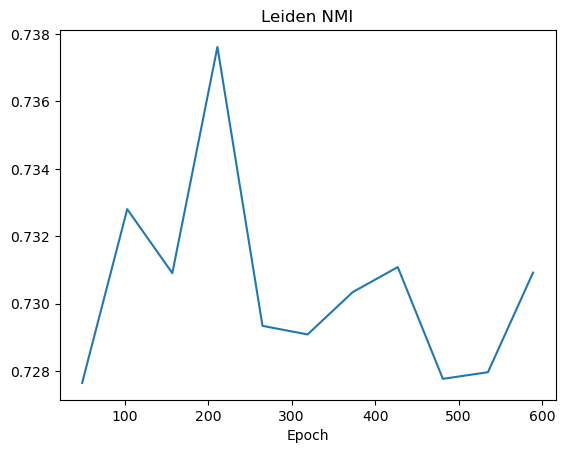

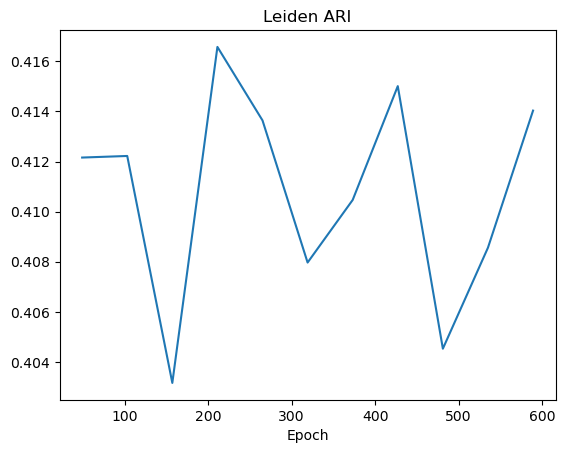

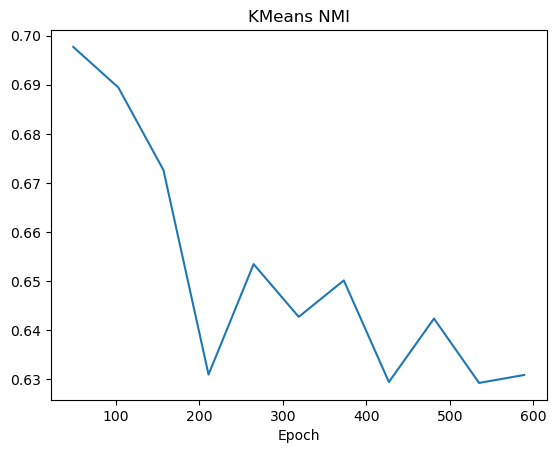

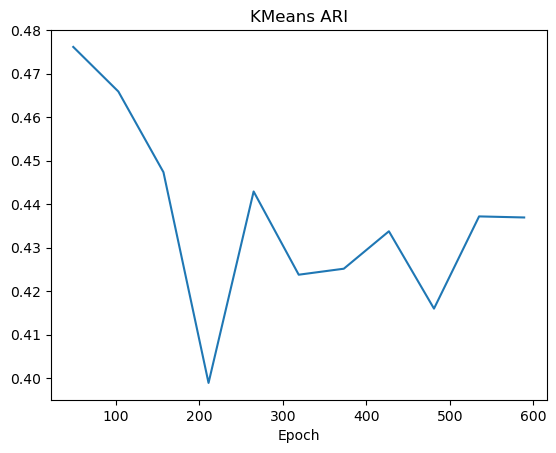

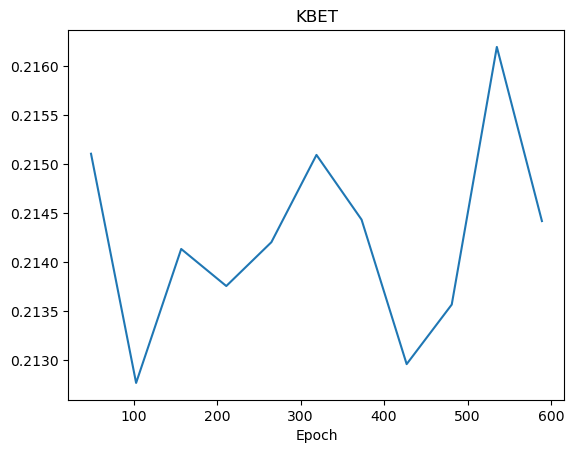

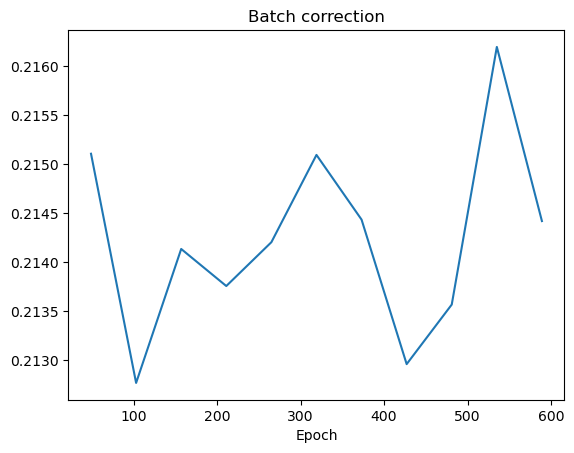

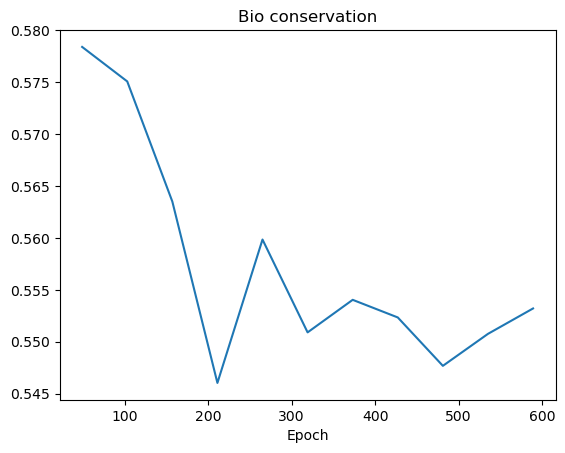

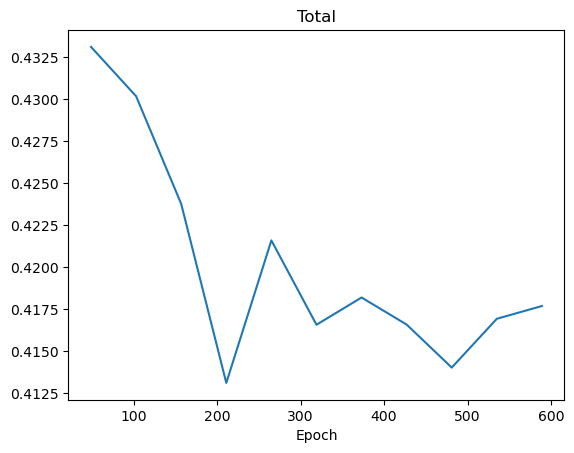

In [ ]:
plotMetricsEpochs(bmSD,295,5)

In [ ]:
trainMetricsEpochs(vaeMG, "MetEp_MG", 5, 200, 300, every_n=5, log=True, logname="MetEps300MG")
bmMG = getBenchmarkResultsEpochs(adata,"models/MetEp_MG/",300,5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 600/600: 100%|██████████| 600/600 [23:51<00:00,  2.59s/it, v_num=1, train_loss_step=914, train_loss_epoch=880]    

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [23:51<00:00,  2.39s/it, v_num=1, train_loss_step=914, train_loss_epoch=880]
INFO     File models/MetEp_MG/epoch=49/model.pt already downloaded                                                 
INFO     File models/MetEp_MG/epoch=99/model.pt already downloaded                                                 
INFO     File models/MetEp_MG/epoch=149/model.pt already downloaded                                                
INFO     File models/MetEp_MG/epoch=199/model.pt already downloaded                                                
INFO     File models/MetEp_MG/epoch=249/model.pt already downloaded                                                
INFO     File models/MetEp_MG/epoch=299/model.pt already downloaded                                                
INFO     File models/MetEp_MG/epoch=349/model.pt already downloaded                                                
INFO     File models/MetEp_MG/epoch=399/model.pt already downloaded    

Embeddings: 100%|██████████| 11/11 [04:51<00:00, 26.48s/it]


In [ ]:
plotMetricsEpochs(bmMG,295,5)

In [ ]:
trainMetricsEpochs(vaeVP, "MetEp_VP", 5, 200, 300, every_n=5, log=True, logname="MetEps300VP")
bmVP = getBenchmarkResultsEpochs(adata,"models/MetEp_VP/",300,5)

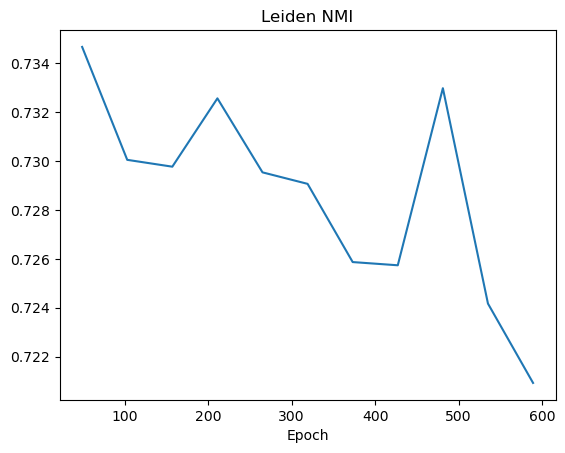

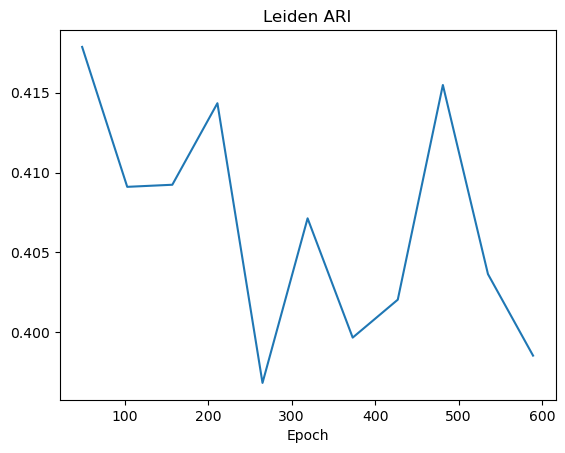

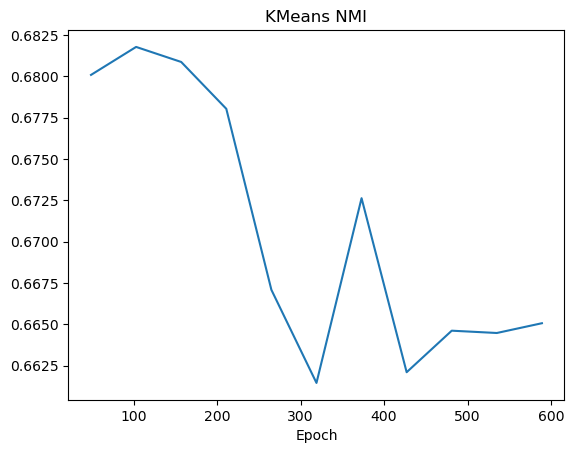

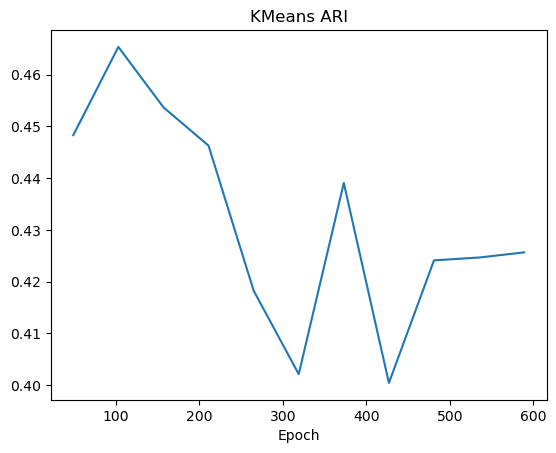

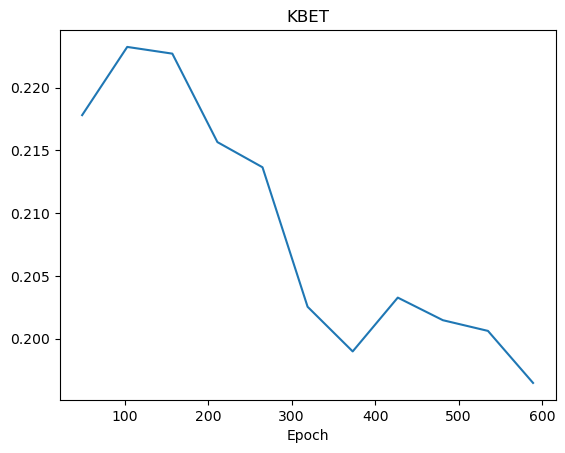

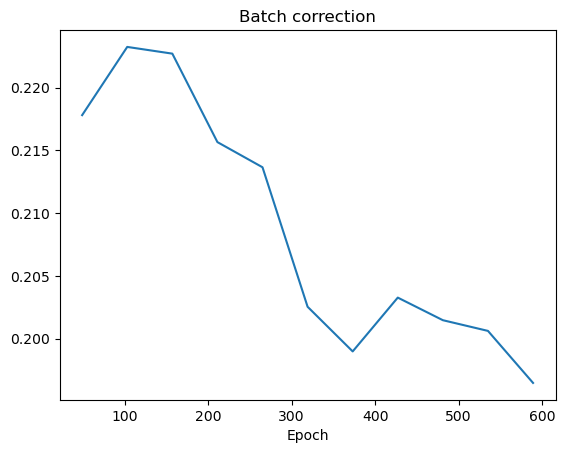

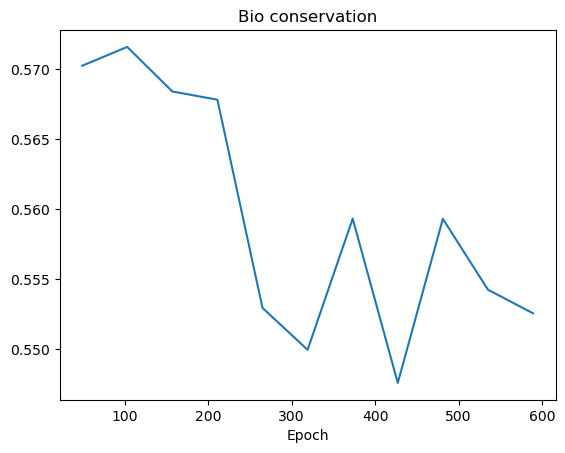

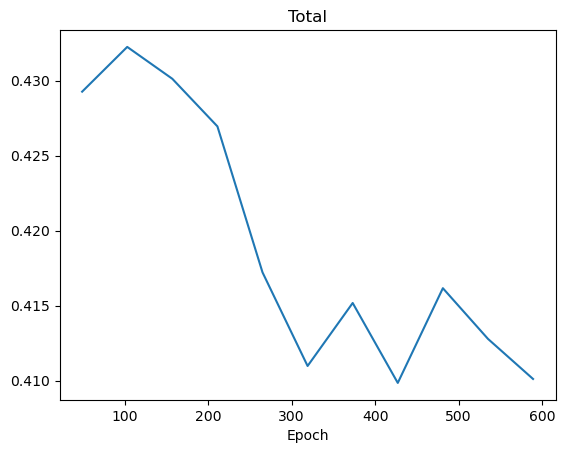

In [ ]:
plotMetricsEpochs(bmVP,295,5)

In [ ]:
trainMetricsEpochs(vaeNF, "MetEp_NF", 5, 200, 300, every_n=5, log=True, logname="MetEps300NF")
bmNF = getBenchmarkResultsEpochs(adata,"models/MetEp_NF/",300,5)

In [ ]:
plotMetricsEpochs(bmNF,295,5)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/